### Diabetic Retinopathy - a NN application

---
**Note1**: This notebook is part of Stanford's BIODS220, Assignment 1, Part a: Diabetic Retinopathy 

Link to source: https://biods220.stanford.edu/assignments.html

Please do not distribute without referencing the original source.

**Note2**: I slightly altered the original notebook to better reflect the topic of our today's class

**Note3***: To run this notebook on a local machine download the data here instead (this is actually why I did for this class):

https://www.kaggle.com/c/aptos2019-blindness-detection/data?select=test_images

---

Diabetic retinopathy (DR) is an eye disease prevalent in diabetic patients. It is the leading cause of blindness in people aged 20-64. Screening for DR allows earlier and more effective treatment options, and accurate screening can save the eyesight of millions. A deep-learning approach to predicting DR from eye images was proposed in 2016, in the paper "Development and Validation of a Deep Learning Algorithm for Detection of Diabetic Retinopathy in Retinal Fundus Photographs", published in JAMA.

In this assignment we will use a similar dataset of retina images hosted by Kaggle. We'll train a model to predict whether or not to refer a patient for treatment given binarized severity of DR in patients: no referral if [No DR, mild] and referral if [moderate, severe, and proliferate DR].

## Section 1: Data

Let's first explore the dataset, which is hosted by Kaggle. Go to https://www.kaggle.com/c/diabetic-retinopathy-detection/data, create a Kaggle account, then accept the competition rules after clicking the "Late Submission" button. 

In your working environment run ```pip install kaggle```.

Go to the ‘Account’ tab of your user profile and select ‘Create New API Token’. Your personal `kaggle.json` file, which contains your Kaggle username and key, will download. Copy in your username and key to the following lines and run it in your Terminal to set these variables in your environment.

```export KAGGLE_USERNAME=your_user_name```

```export KAGGLE_KEY=your_key```


Downloading this dataset takes a while, so we recommend you use ```screen``` or ```tmux``` and do other tasks. Run the following in the directory where you want to put the data. 

```kaggle competitions download -c diabetic-retinopathy-detection``` (about 25 - 30 min)

```unzip diabetic-retinopathy-detection.zip "train*"``` (~25 min)

```rm diabetic-retinopathy-detection.zip  #``` Do this **after** running the unzip command.

```cat train.zip.* > train.zip``` (~20 min)

```unzip train.zip``` (~15 min)

```unzip trainLabels.csv.zip``` (~1 min)

You'll now have a directory called `train/` with the images we'll use for this notebook.


___
**Q1a.1**: Read over the data descriptions from Kaggle. Write down the source of data and list the the two ways that images are shown.


*Written answer*:

Data source: Retinal images were provided by EyePACS, a free platform for retinopathy screening.

Two ways the images are shown:
- some images are shown as one would see the retina anatomically (macula on the left, optic nerve on the right for the right eye)
- others are shown as one would see through a microscope condensing lens (i.e. inverted, as one sees in a typical live eye exam). 
___

Import the necessary libraries and set our path by running the cell below. Replace IMAGE_PATH with the path to the `train` directory with all the images. Replace LABEL_PATH with the path to `trainLabels.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from sklearn.metrics import roc_curve
import kaggle
import seaborn as sns

random.seed(2) # don't change this

# FILL IN CODE HERE #

IMAGE_PATH = '/home/cilin/assign1/train_images/' # replace with your path
LABEL_PATH = '/home/cilin/assign1/train_labels/' # replace with your path

# FILL IN CODE HERE #

Before beginning the data processing, let's first analyze the composition of our dataset.

___
**Q1a.2**: There are five classes: No DR (0), mild (1), moderate (2), severe (3), and proliferate DR (4). Graph a histogram for the classes. Write down the percentage of the largest class in the written answer below. 

Hints: use a pandas DataFrame to read the labels data. To create the histogram, you can either use pandas, or a combination of numpy and matplotlib.


*Written answer*:

Most of the examples (49.3 percent) belong to class 0.
___

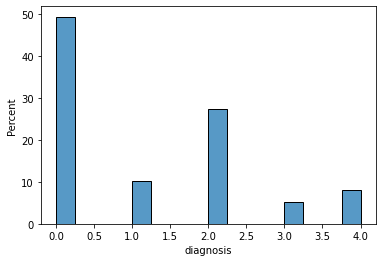

In [2]:
# FILL IN CODE HERE #
def read_train_labels():
    ''''''
    return pd.read_csv(
        LABEL_PATH + 'train.csv'
    )

# read the data
y_train = read_train_labels()

# plot histogram
sns.histplot(
    data=y_train,
    stat="percent",
    x = "diagnosis"
);

___
**Q1a.3**: As you can see from the histogram, our dataset is very imbalanced. Imbalanced datasets are common in healthcare, especially in ophthalmology and pathology. 

Give one reason why imbalanced datasets are common in health care, and suggest a problem that imbalanced data could cause. 


*Written answer*:

- some healthcare events (diseases) are rare, resulting in massive unstructured datasets
- the presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume an equal occurrence of classes and are designed to maximize the overall classification accuracy
___

We want to use a deep learning model to refer patients to doctors based on the severity of risk seen in fundus photos. Therefore we will explore binary classification of 'no refer' and 'refer'. We will need binary labels, bucketing:
-  [No DR, mild] are 'no refer'
- [Moderate, Severe, Proliferate] are 'refer'. 

Because our dataset is imbalanced, we'll take 2000 random samples from 'no refer' calss and 2000 random samples from 'refer' class. (This is the crudest method for dealing with imbalanced data, but it will be good enough to get decent results in this exercise). 

**Q1a.4**: DR levels [0, 1] will be 'no refer' and DR levels [2, 3, 4] will be 'refer'. Randomly sample 2000 from each type by creating 2 lists of image filenames: `no_refer_examples` and `refer_examples`. For example, refer_examples will consist of ['11503_right', '44093_right', etc], if these image names are DR levels 2, 3, or 4. 


In [3]:
no_refer_examples = y_train[y_train.diagnosis.isin((0,1))]
refer_examples = y_train[y_train.diagnosis.isin((2,3,4))]

# randomly draw 1000 images from both classes
temp_no_refer = list(np.random.choice(
    no_refer_examples.id_code,
    size=1000,
    replace=False
))

temp_refer = list(np.random.choice(
    refer_examples.id_code,
    size=1000,
    replace=False
))

**Q1a.5**: Complete the `load_data` function to generate a train/validation/test sets with split `(0.6,0.2,0.2)`.


Read in the images and labels to numpy arrays using Keras functions `load_img` and ```img_to_array```. (If you get a dependency error for `Pillow`, then just run `pip install Pillow` in the VM terminal.) For each image: 
- resize to ```IMAGE_SIZE``` using ```cv2``` with interpolation flag `INTER_LANCZOS4`
- normalize the pixels in each image with the max and min pixel value of that image (so each image will have min pixel value 0, and max pixel value 1.

The expected shapes of the output are:
- `X_train`  is`(2400, 224, 224, 3)`; `X_val` and `X_test`  is `(800, 224, 224, 3)`
- `y_train`  is `(2400,)`; `y_val` and `y_test`  is `(800,)`


In [4]:
IMAGE_SIZE = (224, 224)

def load_data(IMAGE_PATH, LABEL_PATH, split=(0.6,0.2,0.2)):
    """
    Load batches of images and labels. Splits images and labels 
    into arrays 
    
    Parameters:
    IMAGE_PATH (str/path): path to directory with images.
    LABEL_PATH (str/path): path to directory with labels.
    split (tuple): 3 values summing to 1 defining split of train, validation and test 
    
    Returns:
    X_train (np.ndarray): Train images. A numpy array of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels. A numpy array of shape (N_train,)
    X_val (np.ndarray): Val images. A numpy array of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels. A numpy array of shape (N_val,)
    X_test (np.ndarray): Test images. A numpy array of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels. A numpy array of shape (N_test,)
    """
    train_images = []
    train_labels = []
    
    # FILL IN CODE HERE #
    # create lists of images and labels `train_images` and `train_labels`#
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        if img.split('.')[0] in temp_no_refer:
            train_labels.append(0)
        elif img.split('.')[0] in temp_refer:
            train_labels.append(1)
        else:
            continue

        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=IMAGE_SIZE
        )

        # transform image to array
        img = img_to_array(img)
        train_images.append(img)
    

    # FILL IN CODE HERE #
    
    all_images = np.stack(train_images)
    all_labels = np.array(train_labels).flatten() 
    
    # rescale images to [0,1], i.e., greyscale
    all_images = all_images/255.0

    # FILL IN CODE HERE #
    # Split train/val/test by creating the returned variables # 
    # NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
    shuffle = np.random.permutation(np.arange(all_images.shape[0]))
    all_images, all_labels = all_images[shuffle], all_labels[shuffle]
    
    X_train, y_train = all_images[:1200], all_labels[:1200]
    X_val, y_val = all_images[1200:1600], all_labels[1200:1600]
    X_test, y_test = all_images[1600:], all_labels[1600:]
    
    # FILL IN CODE HERE #
    
    return X_train, y_train, X_val, y_val, X_test, y_test, all_images

X_train, y_train, X_val, y_val, X_test, y_test, all_images = load_data(IMAGE_PATH, LABEL_PATH, split=(0.6,0.2,0.2))
#all_images, all_labels = load_data(IMAGE_PATH, LABEL_PATH, split=(0.6,0.2,0.2))

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")


X_train shape (1200, 224, 224, 3)
y_train shape (1200,)
X_val shape (400, 224, 224, 3)
y_val shape (400,)
X_test shape (400, 224, 224, 3)
y_test shape (400,)


This processing should take around 15 minutes to finish. 

We recommend saving the data to a file using the next cell. Once you've done that, comment out that cell. When you need to load this data again in the future, ybcommenting out the code in the cell after and run it.

In [5]:
"""
# This method loads your data
saved_data_path=''
with open(saved_data_path, 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f)
    X_val = np.load(f)
    y_val = np.load(f)
    X_test = np.load(f)
    y_test = np.load(f)
"""

"\n# This method loads your data\nsaved_data_path=''\nwith open(saved_data_path, 'rb') as f:\n    X_train = np.load(f)\n    y_train = np.load(f)\n    X_val = np.load(f)\n    y_val = np.load(f)\n    X_test = np.load(f)\n    y_test = np.load(f)\n"

Let's sanity check our load data function by printing out the first five train examples with the label of each example as the title.

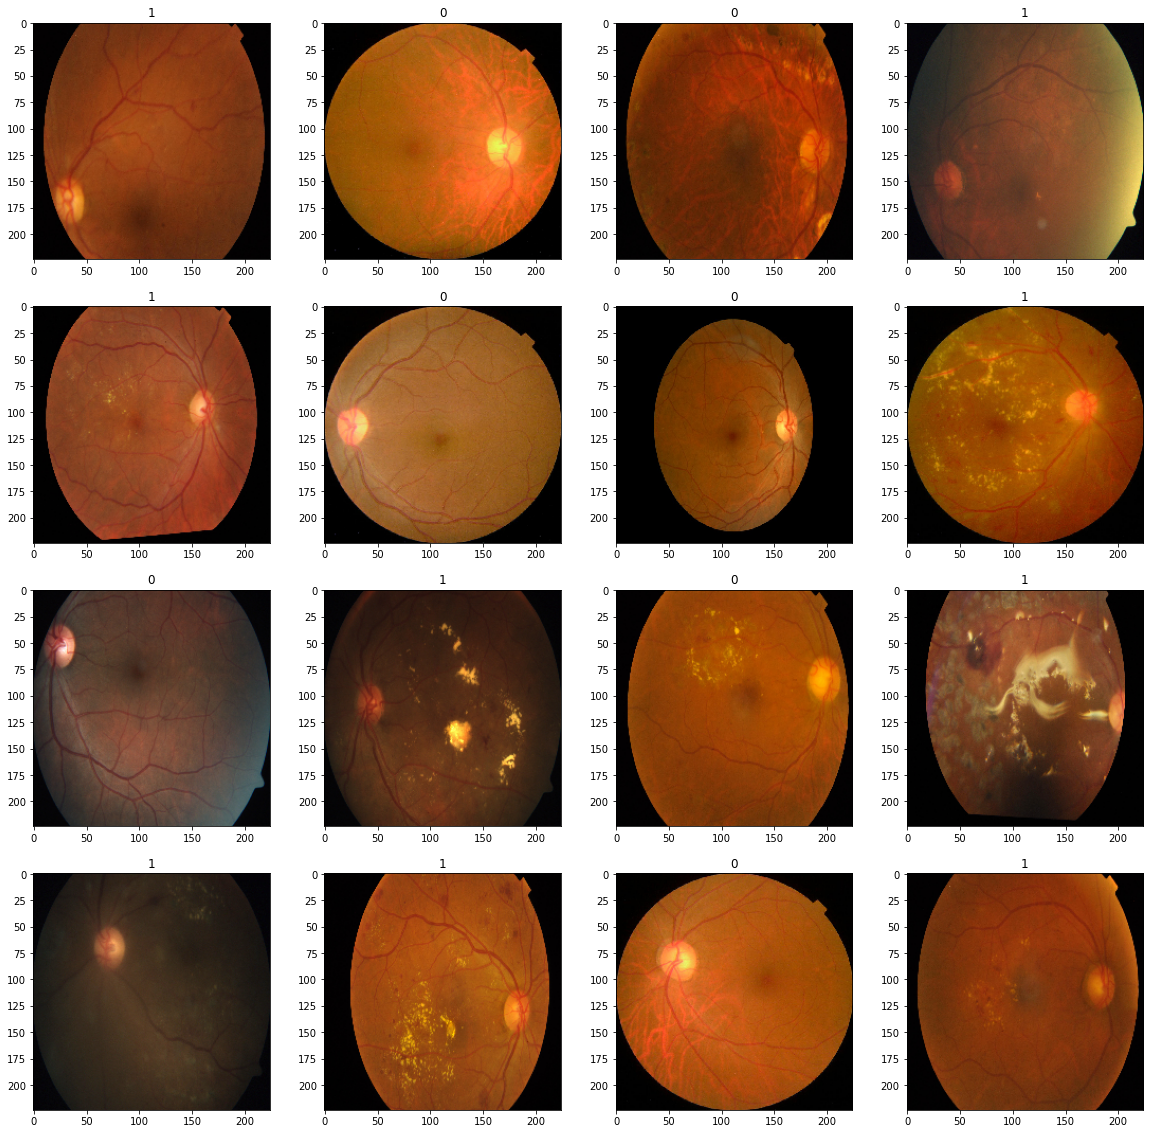

In [6]:
nrows, ncols = 4,4
f, axs = plt.subplots(nrows, ncols, figsize=(20,20))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(array_to_img(X_train[indx]))
        axs[i,j].set(title=y_train[indx])

___
**Q1a.6**: We've split the input into train, validation, and test sets. We will now train the model with the train set, and use performance on the validation set to tune hyperparameters. Finally, we will evaluate on the test set.

Explain the purpose of the test set, and why we don't use it till the end of the analysis. 

*Written answer*:

[add here]
___

Run the below cells to create train, validation, and test datasets from our preprocessed data.

In [7]:
# create data for batch gradient descent
BATCH_SIZE = 10

train_dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


2021-10-07 16:33:43.143962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 16:33:43.156249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 16:33:43.156982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 16:33:43.161224: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Section 2: Model

**Q1a.7**: Let's create a base model for DR using keras. 

Use `tf.keras.Sequential` to add your layers

Compile your model using the Keras commands and include:
- An appropriate loss function for binary classification.
- Use the `Adam` optimizer with initial learning rating of 0.1. 
- Add the `accuracy` metric. 

In [22]:
# FILL IN CODE HERE #
model = tf.keras.Sequential([
    # the first layer transforms the format of the images (to a 1D array of 224*224 = 50176 pixels)
    # this layer has no params or weights to learn, it only reformats the data
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    # the second layer is a dense layer (i.e., the nodes are fully connected)
    # this layer has 1280 nodes (play around with this value!), and it uses the activation function Rectified Linear Unit
    tf.keras.layers.Dense(2450, activation='relu'),
    # the third layer is a dropout layer
    # makes it so some of the nodes in a given layer don’t pass on their information to the next layer. 
    # this helps with computation time (less parameters) and with overfitting.
    # each node in the second  layer has a 0.4 probability of being dropped from the computation of the activations of the next layer. 
    tf.keras.layers.Dropout(0.2),
    # the fourth (and last) layer, which is the output layer, returns a logits array of length 2
    # each node contains a probability that indicates the current image belongs to one of the 2 classes
    # note that the size of the output layer is always equal with the number of classes in the dataset
    # it uses the activation function Sigmoid because we deal with a binary classification problem
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 2450)              368796050 
_________________________________________________________________
dropout_2 (Dropout)          (None, 2450)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2451      
Total params: 368,798,501
Trainable params: 368,798,501
Non-trainable params: 0
_________________________________________________________________


In [23]:
# FILL IN CODE HERE #
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# The loss (cost) function for this particular model is
# ‘binary_crossentropy’ which is good for binary-classification problems like this one.
# Check here for more optimizer options: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

**Q1a.8**: Call ```model.fit``` (https://keras.io/models/model/) with 10 epochs on the train set and validate on the validation set. Don't worry, you should get poor performance for these current starter hyperparameters. This could be due to learning rate, choice of optimizer, or choice of loss function.

Tune your learning rate, and rerun ```model.fit``` to achieve better accuracy on the tune set. You should be able to get above 0.9 accuracy for train and above 0.6 accuracy for validation. Report your accuracies below.

In [24]:
# FILL IN CODE HERE #
# model fit
history = model.fit(
    train_dset,
    epochs=10
)

Epoch 1/10
120/120 [==============================] - 17s 138ms/step - loss: 230.5036 - accuracy: 0.6858
Epoch 2/10
120/120 [==============================] - 17s 138ms/step - loss: 3.8889 - accuracy: 0.7650
Epoch 3/10
120/120 [==============================] - 17s 138ms/step - loss: 1.5611 - accuracy: 0.8000
Epoch 4/10
120/120 [==============================] - 17s 138ms/step - loss: 0.7827 - accuracy: 0.8275
Epoch 5/10
120/120 [==============================] - 17s 139ms/step - loss: 0.5537 - accuracy: 0.8208
Epoch 6/10
120/120 [==============================] - 17s 139ms/step - loss: 0.3656 - accuracy: 0.8258
Epoch 7/10
120/120 [==============================] - 17s 139ms/step - loss: 0.3707 - accuracy: 0.8250
Epoch 8/10
120/120 [==============================] - 17s 138ms/step - loss: 0.3658 - accuracy: 0.8233
Epoch 9/10
120/120 [==============================] - 17s 138ms/step - loss: 0.4121 - accuracy: 0.8167
Epoch 10/10
120/120 [==============================] - 17s 138ms/step -

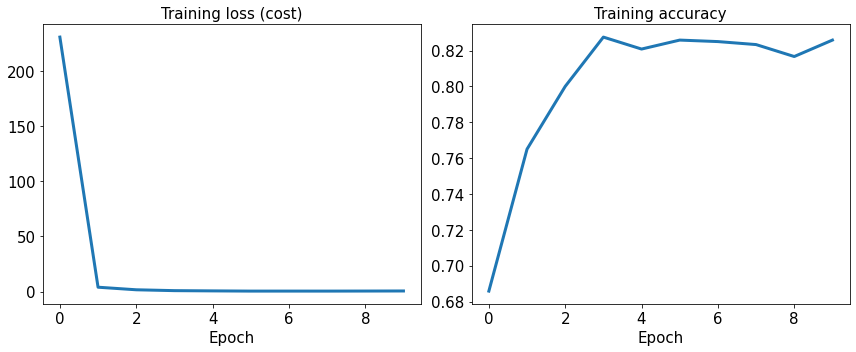

In [25]:
# plot training cost and accuracy
hist = history.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss (cost)', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

In [26]:
# validate the model
val_loss, val_acc = model.evaluate(val_dset, verbose=2)

print('\nValidation accuracy:', val_acc)

40/40 - 2s - loss: 0.4162 - accuracy: 0.8500

Validation accuracy: 0.8500000238418579


*Accuracy for tune*:

*Accuracy for validation*:

---
**Q1a.9**: Tuning hyperparameters is crucial to deep learning! Explain the changes you made to tune the model, and suggest why it may have improved training. 

*Written answer*:

[add here]

---

## Section 3: Evaluation

Evaluation is one of the most important parts of medical classification, as it helps us determine what to do with the model predictions and how it can improve screening processes. 

We've used the train and test set to create the model. Notice that (`X_test`, and `y_test`) were not used in that process. It would be very bad practice to evaluate the model on the test set, and then return and update the model based on those results (then the test set is acting like just another validation set). 

We'll explore different ways to assess our model in the next questions.

**Q1a.10**: The simplest evaluation is accuracy. Use ```model.evaluate``` (https://keras.io/models/model/) with ```X_test``` and ```y_test``` and print the test accuracy (this will work if you compiled the model with the accuracy metric earlier). You should have an accuracy of above 0.6.

In [16]:
# FILL IN CODE HERE #
test_loss, test_acc = model.evaluate(test_dset, verbose=2)

print('\nTest accuracy:', test_acc)

# FILL IN CODE HERE #

40/40 - 1s - loss: 0.5314 - accuracy: 0.8100

Test accuracy: 0.8100000023841858


**Q1a.11**: Let's go deeper by considering the balance of false-positive and false-negative rates. Use `sklearn.metrics.roc_curve` to compute false-positive and true-positive rates at different levels of binary threshold. 
Plot the ROC curve, and then use `sklearn.metrics.roc_auc_score` to compute the AUC (area under the curve of the ROC curve). 

In the written answer below, interpret what the AUC means.


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
def check_binarized_auc(test_dset, model):
    """
    Given a trained model and test dataset, compute the parameters of the ROC curve
    and compute the AUC. 
    
    Parameters:
    test_dset (tf.data.Dataset): test dataset
    model (tf.keras.model): prediction model
    
    Returns: 
    fpr (np.ndarray): same as docstring of sklearn.metrics.roc_curve
    tpr (np.ndarray): same as docstring of sklearn.metrics.roc_curve
    thresholds (np.ndarray): same as docstring of sklearn.metrics.roc_curve
    auc (float): area under the ROC curve for the curve defined by fpr, tpr, and thresholds.
    """
    # FILL IN CODE HERE #
    
    # FILL IN CODE HERE #
    return fpr, tpr, thresholds, auc

fpr, tpr, thresholds, auc = check_binarized_auc(test_dset, model)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
print(f"AUC score={auc}")

*Written answer*:

**Q1a.12**: Finally, let's choose an operating point using Youden’s index (https://en.wikipedia.org/wiki/Youden%27s_J_statistic) and report its sensitivity and specificity at that point.

In [ ]:
def choose_operating_point(fpr, tpr, thresholds):
    """
    Given ROC curve parameters, choose an operating point 
    using the Youden J statistic 
    
    Parameters: 
    fpr, tpr, thresholds (np.ndarray): same as docstring for `check_binarized_auc`
    
    Returns:
    op_point (float): operating point threshold for binary task chosen with Youdens J statistic
    sens (float): test dataset sensitivity score, https://en.wikipedia.org/wiki/Sensitivity_and_specificity
    spec (float): test dataset specificity score, https://en.wikipedia.org/wiki/Sensitivity_and_specificity
    """
    
    # FILL IN CODE HERE #
    
    # FILL IN CODE HERE #
    return op_point, sens, spec

op_point, sens, spec = choose_operating_point(fpr, tpr, thresholds)
print(f'Operating point: {op_point}')
print(f'Sensitivity: {sens}')
print(f'Specificity: {sens}')

**Q1a.13**: What does it mean to choose an operating point with high sensitivity, and an operating point with high specificity? List one medical application where high sensitivity is needed, and one when high specificity is needed.

*Written answer*: